# Cleanalyze

Original author: **Frank Peeters** (*f.j.c.peeters@vu.nl*)<br>
Associate Professor Vrije Universiteit Amsterdam

Modified by: **Sanne Nauta**<br>
BSc student Vrije Universiteit Amsterdam

Translation to Python and further modification: **Niels J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

Cleans and analyzes a time series dataset (one x column) in the following steps:

1. Remove outliers using the Hampel function
2. Average duplicate rows using the unique function
3. Convert x y data to equally space data in x
4. Detrend data
5. Gaussian smoothing
6. Identification of local maxima in Gaussian filter (above a given threshold)
7. LOESS smoothing
8. Peak detection with moving window local maximum on top of LOESS smoothing
9. D-square algorithm for local peak detection
10. Cluster peaks found by D-square that are very close together
11. Combine peak information from multiple methods and select 7 most prominent peaks
12. Label and export data by peak and in-between interval

## Load packages

In [1]:
import os # Module to interact with the operating system and save files
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap # Function used to map colors for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

## Load data

In [2]:
# Load the data
data = pd.read_csv('G767_sub.csv')
specimen = 'G767_sub' # Select specimen
proxy = '88Sr/43Ca' # Select proxy to work with (in this case always Sr/Ca)

---
# Prepare data

In [3]:
data = data.iloc[1 : ].reset_index(drop = True) # Remove the first row of the data
data = data.apply(pd.to_numeric, errors = 'coerce') # Convert all columns to numeric types
data['depth'] = data['depth'] * 1000 # Change mm to um

## 1. Use Hampel filter to remove outliers

In [4]:
# Define the Hampel function
def hampel(vals_orig, k = 7, t0 = 3):
    vals = vals_orig.copy()  # Make copy so original not affected
    L = 1.4826  # Set constant to align with 1 sigma (MAD is approximately 0.6745 * SD)
    rolling_median = vals.rolling(window = 2 * k, center = True).median()  # Calculate median with window k
    difference = np.abs(rolling_median - vals)  # Calculate difference between values and median
    median_abs_deviation = difference.rolling(window = 2 * k, center = True).median()  # Calculate MAD
    threshold = t0 * L * median_abs_deviation  # Calculate threshold for outliers
    outlier_idx = difference > threshold  # Find outlier indices
    vals[outlier_idx] = rolling_median[outlier_idx]  # Replace outliers with rolling median
    return vals, outlier_idx  # Return the corrected series and the indices of outliers

# Apply Hampel filter to the proxy column
proxy_filtered, outlier_idx = hampel(data[proxy], k = 7, t0 = 3)
ts0 = np.column_stack((data['depth'], proxy_filtered))
ts0 = pd.DataFrame(ts0, columns=['depth', 'proxy_filtered'])
print(f'{outlier_idx.sum()} outliers were identified and replaced with the local median')

536 outliers were identified and replaced with the local median


## Plot result of outlier removal

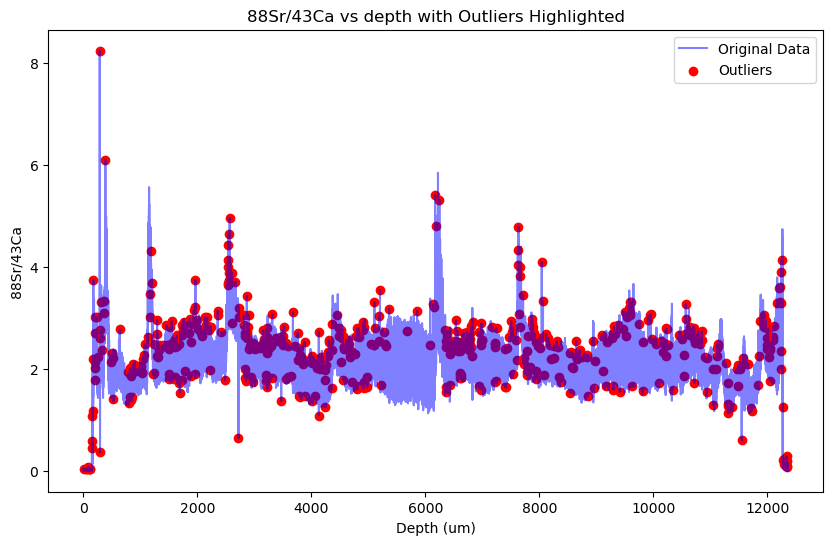

In [5]:
plt.figure(figsize = (10, 6))
plt.plot(data['depth'], data[proxy], label = 'Original Data', color = 'blue', alpha = 0.5)
plt.scatter(data['depth'][outlier_idx], data[proxy][outlier_idx], color = 'red', label = 'Outliers')
plt.xlabel('Depth (um)')
plt.ylabel(proxy)
plt.title(f'{proxy} vs depth with Outliers Highlighted')
plt.legend()
plt.show()

## 2. Average duplicate values (with the same depth value)

In [6]:
# 2). AVERAGE DUPLICATE X-DATA
unique_x, indices, counts = np.unique(ts0['depth'], return_inverse = True, return_counts = True) # Find unique x-values and their indices
ts1 = pd.DataFrame(np.zeros((len(unique_x), 2)), columns=['depth', 'proxy_filtered']) # Create an empty dataframe to store the averaged data
ts1['depth'] = unique_x # Store the unique x-values in the first column
ts1['proxy_filtered'] = np.bincount(indices, weights = ts0['proxy_filtered']) / counts # Average the y-values based on the x-values
print(f'{len(ts0['depth']) - len(unique_x)} duplicates were identified and replaced with the average value')

# Calculate the mean uncertainty (standard deviation) based on the duplicates
# Calculate the standard deviation for each set of duplicates
std_devs = np.zeros(len(unique_x))
for i in range(len(unique_x)):
    duplicate_indices = np.where(indices == i)[0]
    if len(duplicate_indices) > 1:
        std_devs[i] = np.std(ts0['proxy_filtered'].iloc[duplicate_indices])

# Calculate the combined standard deviation
combined_variance = np.sum(std_devs[std_devs > 0]**2)  # Sum of variances
combined_std_dev = np.sqrt(combined_variance / np.sum(counts > 1))  # Combined standard deviation
print(f'Combined standard deviation of the proxy from duplicates: {combined_std_dev:.3g} mmol/mol')

161 duplicates were identified and replaced with the average value
Combined standard deviation of the proxy from duplicates: 0.221 mmol/mol


## Plot location of duplicate values

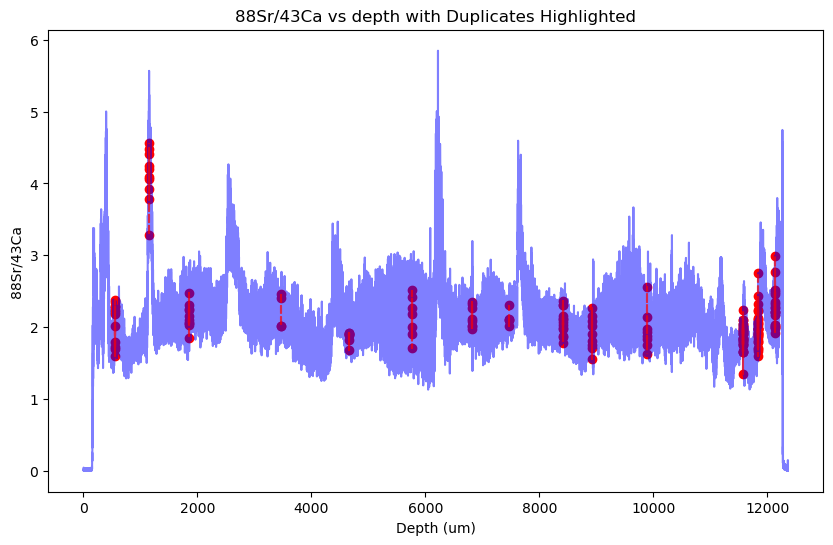

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(ts0['depth'], ts0['proxy_filtered'], label = 'Filtered Data', color = 'blue', alpha = 0.5)

# Highlight and connect duplicate values
for i in range(len(unique_x)):
    duplicate_indices = np.where(indices == i)[0]
    if len(duplicate_indices) > 1:
        plt.scatter(ts0['depth'].iloc[duplicate_indices], ts0['proxy_filtered'].iloc[duplicate_indices], color = 'red')
        plt.plot(ts0['depth'].iloc[duplicate_indices], ts0['proxy_filtered'].iloc[duplicate_indices], color = 'red', linestyle = '--', alpha = 0.7)

plt.xlabel('Depth (um)')
plt.ylabel(proxy)
plt.title(f'{proxy} vs depth with Duplicates Highlighted')
plt.show()

## 3. Make data equally spaced in the depth domain

In [8]:
# 3). MAKE DATA IN X EQUAL SPACED
Xinterpol = np.arange(0.5, np.floor(np.max(ts1['depth'])) + 0.5, 0.5) # Create a new x-axis with 0.5 um spacing
interp_func = interp1d(ts1['depth'], ts1['proxy_filtered'], kind = 'linear') # Create an interpolation function
ts2 = pd.DataFrame(np.column_stack((Xinterpol, interp_func(Xinterpol))), columns = ['depth', 'proxy_filtered']) # Interpolate the y-values based on the new x-values
print(f'Linearly interpolated data to {len(ts2['depth'])} values with 0.5 um spacing')

Linearly interpolated data to 24720 values with 0.5 um spacing


## Plot linearly spaced data on top of original data

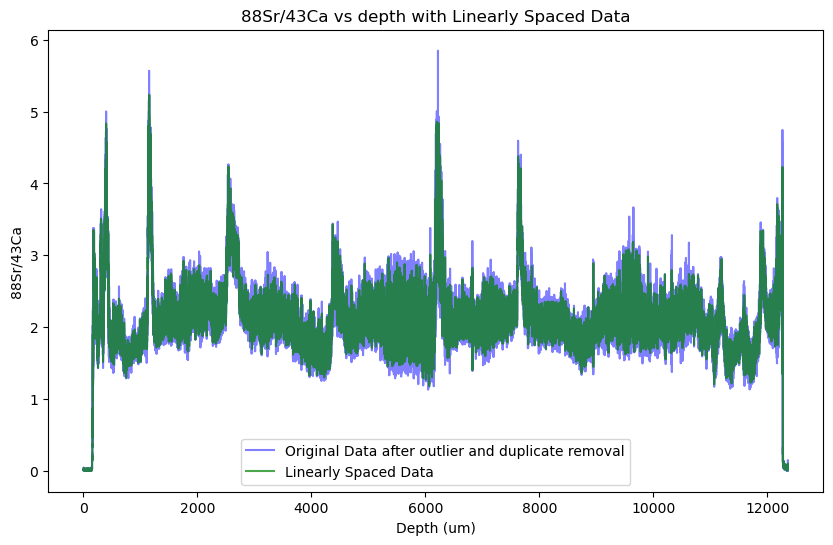

In [9]:
plt.figure(figsize = (10, 6))
plt.plot(ts1['depth'], ts1['proxy_filtered'], label = 'Original Data after outlier and duplicate removal', color = 'blue', alpha = 0.5)
plt.plot(ts2['depth'], ts2['proxy_filtered'], label = 'Linearly Spaced Data', color = 'green', alpha = 0.7)
plt.xlabel('Depth (um)')
plt.ylabel(proxy)
plt.title(f'{proxy} vs depth with Linearly Spaced Data')
plt.legend()
plt.show()

## 4. Detrend data if necessary

In [10]:
from scipy.stats import linregress

# FIXME: 4). DETREND DATA
nan_rows = np.isnan(ts2).any(axis = 1)
ts2_clean = ts2[~nan_rows]

t = ts2_clean['depth']
p = np.polyfit(t, ts2_clean['proxy_filtered'], 3)
f_y = np.polyval(p, t)
detr_data = ts2_clean['proxy_filtered'] - f_y
ts3 = pd.DataFrame(np.column_stack((t, detr_data)), columns = ['depth', 'proxy_detrended'])

# Calculate and print the statistics of the polynomial trend
residuals = ts2_clean['proxy_filtered'] - f_y
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ts2_clean['proxy_filtered'] - np.mean(ts2_clean['proxy_filtered']))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f'R-squared: {r_squared:.3f}')
print(f'Polynomial formula: Proxy = {p[0]:.2e} * depth^3 + {p[1]:.2e} * depth^2 + {p[2]:.2e} * depth + {p[3]:.2e}')

R-squared: 0.047
Polynomial formula: Proxy = 8.93e-13 * depth^3 + -2.52e-08 * depth^2 + 1.81e-04 * depth + 1.82e+00


## Plot polynomial trend and detrended data

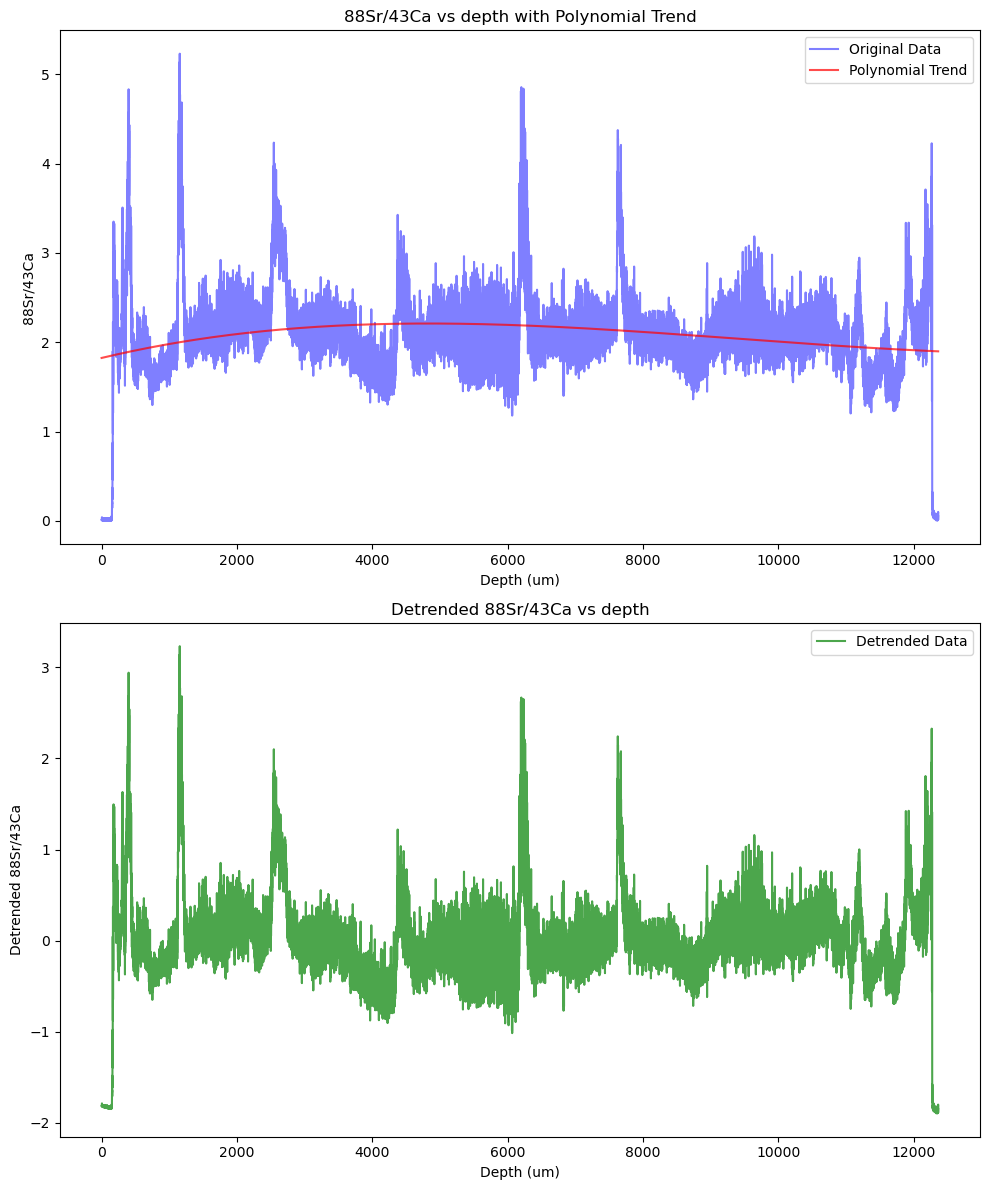

In [11]:
# Plot the original data with the polynomial trend on top of it
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 12))

ax1.plot(ts2_clean['depth'], ts2_clean['proxy_filtered'], label = 'Original Data', color = 'blue', alpha = 0.5)
ax1.plot(ts2_clean['depth'], f_y, label = 'Polynomial Trend', color = 'red', alpha = 0.7)
ax1.set_xlabel('Depth (um)')
ax1.set_ylabel(proxy)
ax1.set_title(f'{proxy} vs depth with Polynomial Trend')
ax1.legend()

# Plot the detrended data
ax2.plot(ts3['depth'], ts3['proxy_detrended'], label = 'Detrended Data', color = 'green', alpha = 0.7)
ax2.set_xlabel('Depth (um)')
ax2.set_ylabel('Detrended ' + proxy)
ax2.set_title(f'Detrended {proxy} vs depth')
ax2.legend()

plt.tight_layout()
plt.show()

---
# ALGORITHM 1: Gaussian smoothing and local maxima

## 5. Apply Gaussian smoothing

In [12]:
# Apply Gaussian filter on detrended data
ts3_gaussian = gaussian_filter1d(ts3['proxy_detrended'], sigma = 20)
ts4 = pd.DataFrame(np.column_stack((ts3['depth'], ts3_gaussian)), columns = ['depth', 'proxy_detrended_gaussian'])

## Plot Gaussian filter and smoothed data

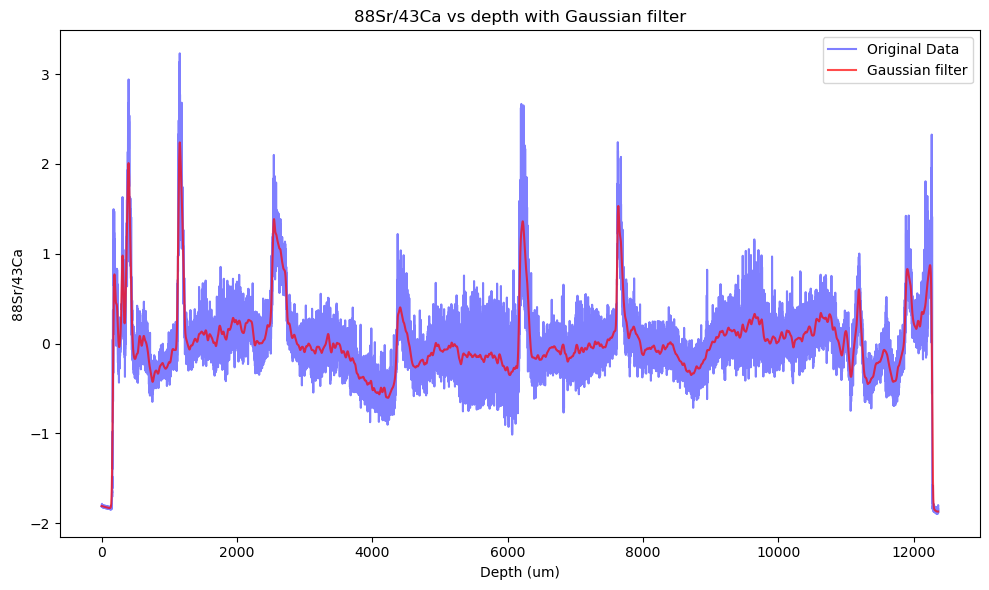

In [13]:
# Plot the original data with the Gaussian filter on top of it
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(ts3['depth'], ts3['proxy_detrended'], label='Original Data', color='blue', alpha=0.5)
ax1.plot(ts3['depth'], ts3_gaussian, label='Gaussian filter', color='red', alpha=0.7)
ax1.set_xlabel('Depth (um)')
ax1.set_ylabel(proxy)
ax1.set_title(f'{proxy} vs depth with Gaussian filter')
ax1.legend()

plt.tight_layout()
plt.show()

## 6. Find peaks in the Gaussian filter

In [14]:
# Use the find_peaks function to identify the peaks in the Gaussian filtered data
pks1_idx, pksdict1 = find_peaks(ts4['proxy_detrended_gaussian'], distance = 1000, height = 0.4, width = [10, 1000])
pks1_depth = ts4['depth'].iloc[pks1_idx] # Get the depths of the peaks
pks1_proxy = ts2['proxy_filtered'].iloc[pks1_idx] # Get the proxy values of the peaks
pks1_depth_left = ts4['depth'].iloc[pksdict1['left_ips']] # Get the left interpolated positions of the peaks
pks1_depth_right = ts4['depth'].iloc[pksdict1['right_ips']] # Get the right interpolated positions of the peaks

# Print details on the 8 major peaks identified
print(f'{len(pks1_depth)} peaks were identified in the data at these locations:')
for i in range(len(pks1_depth)):
    print('Peak {}: Depth = {:.0f} - {:.0f} um with maximum at {:.0f} um, Proxy value = {:.2f} mmol/mol'.format(
        i + 1, pks1_depth_left.iloc[i], pks1_depth_right.iloc[i], pks1_depth.iloc[i], pks1_proxy.iloc[i]))


8 peaks were identified in the data at these locations:
Peak 1: Depth = 363 - 434 um with maximum at 398 um, Proxy value = 4.45 mmol/mol
Peak 2: Depth = 1114 - 1232 um with maximum at 1156 um, Proxy value = 4.77 mmol/mol
Peak 3: Depth = 2516 - 2724 um with maximum at 2548 um, Proxy value = 3.40 mmol/mol
Peak 4: Depth = 4361 - 4533 um with maximum at 4411 um, Proxy value = 2.64 mmol/mol
Peak 5: Depth = 6174 - 6296 um with maximum at 6222 um, Proxy value = 3.06 mmol/mol
Peak 6: Depth = 7608 - 7715 um with maximum at 7634 um, Proxy value = 3.88 mmol/mol
Peak 7: Depth = 11142 - 11226 um with maximum at 11190 um, Proxy value = 2.66 mmol/mol
Peak 8: Depth = 12097 - 12264 um with maximum at 12240 um, Proxy value = 2.79 mmol/mol


## Plot locations of identified peaks on filtered data

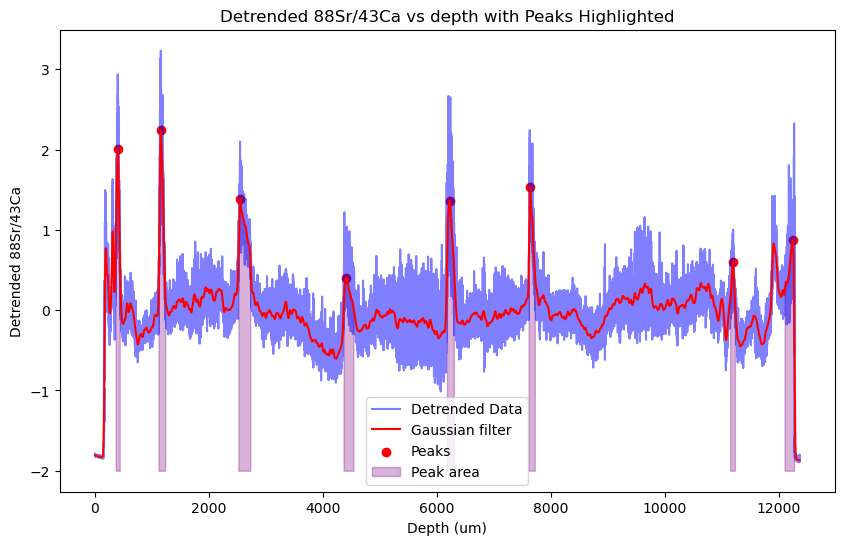

In [15]:
plt.figure(figsize = (10, 6))

plt.plot(ts3['depth'], ts3['proxy_detrended'], label = 'Detrended Data', color = 'blue', alpha = 0.5) # Plot the detrended data
plt.plot(ts4['depth'], ts4['proxy_detrended_gaussian'], label = 'Gaussian filter', color = 'red') # Plot the gaussian filter

# Plot the peaks
plt.scatter(pks1_depth, ts4['proxy_detrended_gaussian'].iloc[pks1_idx], color = 'red', label = 'Peaks')

# Shade the area under the Gaussian filter curve for the full width of the peaks
for i in range(len(pks1_depth)):
    plt.fill_between(ts4['depth'], -2, ts4['proxy_detrended_gaussian'], where = (ts4['depth'] >= pks1_depth_left.iloc[i]) & (ts4['depth'] <= pks1_depth_right.iloc[i]), color = 'purple', alpha = 0.3, label = 'Peak area' if i == 0 else "")

plt.xlabel('Depth (um)')
plt.ylabel('Detrended ' + proxy)
plt.title(f'Detrended {proxy} vs depth with Peaks Highlighted')
plt.legend()
plt.show()

---
# ALGORITHM 2: LOESS Smoothing followed by local maximum searching

## 7. Create LOESS filter of non-detrended data

In [16]:
# 7). LOESS filter
y_smooth = lowess(ts2['proxy_filtered'], ts2['depth'], frac = 0.05, return_sorted = False) # Smooth the data using a LOESS filter
ts5 = pd.DataFrame(np.column_stack((ts2['depth'], y_smooth)), columns = ['depth', 'proxy_loess']) # Store the smoothed data in a new dataframe

## Plot LOESS filter

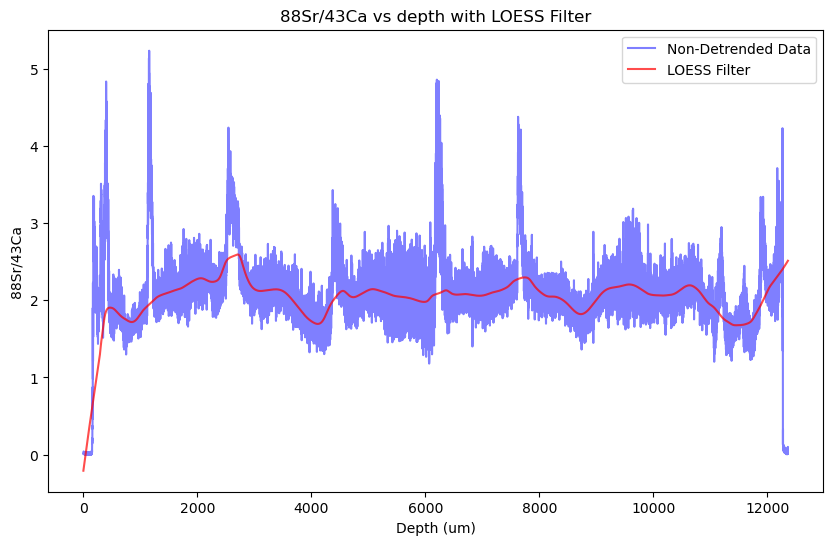

In [17]:
plt.figure(figsize = (10, 6))
plt.plot(ts2['depth'], ts2['proxy_filtered'], label = 'Non-Detrended Data', color = 'blue', alpha = 0.5)
plt.plot(ts5['depth'], ts5['proxy_loess'], label = 'LOESS Filter', color = 'red', alpha = 0.7)
plt.xlabel('Depth (um)')
plt.ylabel(proxy)
plt.title(f'{proxy} vs depth with LOESS Filter')
plt.legend()
plt.show()

## 8. Peak detection with moving window local maximum

### Code inspired by: [Huber, W.A., "Data Smoothing and Peak Detection", Rpubs, Last accessed: March 13th, 2025](https://rpubs.com/mengxu/peak_detection)

6 peaks were identified in the data at these locations:
Peak 1: Depth = 2206 - 2206 um with maximum at 2706 um, Proxy value = 3.11 mmol/mol
Peak 2: Depth = 4577 - 4577 um with maximum at 5077 um, Proxy value = 2.15 mmol/mol
Peak 3: Depth = 5862 - 5862 um with maximum at 6362 um, Proxy value = 1.90 mmol/mol
Peak 4: Depth = 7244 - 7244 um with maximum at 7744 um, Proxy value = 2.59 mmol/mol
Peak 5: Depth = 9076 - 9076 um with maximum at 9576 um, Proxy value = 2.21 mmol/mol
Peak 6: Depth = 10160 - 10160 um with maximum at 10635 um, Proxy value = 2.33 mmol/mol


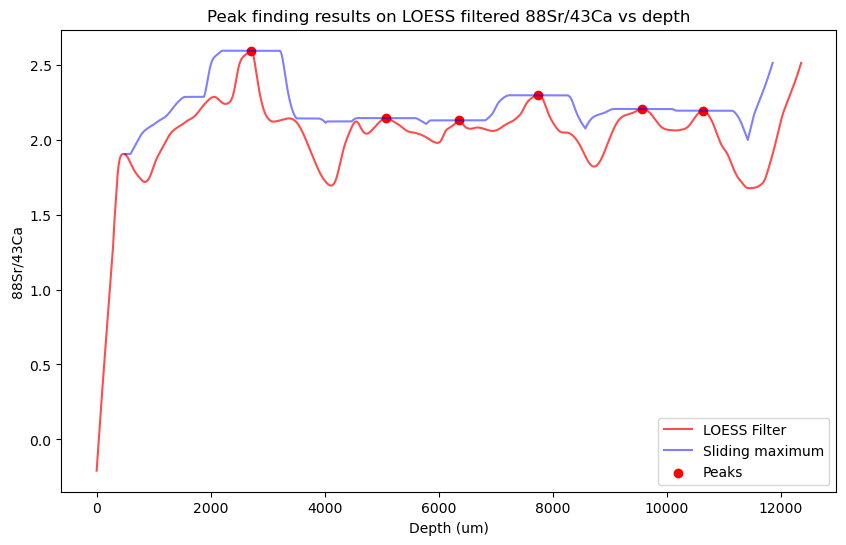

5412      2706.5
10153     5077.0
12723     6362.0
15488     7744.5
19151     9576.0
21269    10635.0
Name: depth, dtype: float64


In [18]:
# 8). Peak detection on top of LOESS

w = 1000 # Window size
n = len(y_smooth) # Number of data points
window_size = 2 * w + 1 # Window size for moving average
y_max = np.array([np.max(y_smooth[i-w:i+w+1]) for i in range(w, n-w)]) # Find the maximum value within the window for each point
y_smooth_trimmed = y_smooth[w:n-w] # Trim the smoothed data to prevent edge effects
delta = y_max - y_smooth_trimmed # Calculate the difference between the moving window maximum and the smoothed data
i_max = np.where(delta <= 0)[0] + w # Find the indices where the difference between smoothed and maximum is less than or equal to zero (peaks)

# Find the indices of duplicates in y_max
duplicate_ranges = []
current_range = []

for i in range(1, len(y_max)): # Loop through y_max
    if y_max[i] == y_max[i - 1]: # Test if value is equal to previous value
        if not current_range: # If the current range is empty
            current_range.append(i - 1) # Add the previous index to the current range
        current_range.append(i) # Add the current index to the current range
    else: # If the value is not equal to the previous value
        if current_range: # If the current range is not empty
            duplicate_ranges.append((current_range[0] + w, current_range[-1] + w)) # Add the current range to the duplicate ranges
            current_range = [] # Reset the current range

# Add the last range if it exists
if current_range:
    duplicate_ranges.append((current_range[0] + w, current_range[-1] + w))

pks2_idx = i_max # Get the indices of the peaks
pks2_depth = ts5['depth'].iloc[i_max] # Get the depths of the peaks
pks2_proxy = ts2['proxy_filtered'].iloc[i_max] # Get the proxy values of the peaks
pks2_depth_left = np.zeros(len(i_max)) # Initialize array to store left edges of peaks
pks2_depth_right = np.zeros(len(i_max)) # Initialize array to store right edges of peaks

# Print details on the 5 major peaks identified
print(f'{len(i_max)} peaks were identified in the data at these locations:')
for i in range(len(i_max)):
    # Find left and right edges of peaks through beginning and ends of the peak's plateau in y_max
    for start, end in duplicate_ranges:
        if start <= i_max[i] <= end:
            pks2_depth_left[i] = ts5['depth'].iloc[start]
            pks2_depth_right[i] = ts5['depth'].iloc[end]
            break
    print(f'Peak {i+1}: Depth = {pks2_depth_left[i]:.0f} - {pks2_depth_left[i]:.0f} um with maximum at {pks2_depth.iloc[i]:.0f} um, Proxy value = {pks2_proxy.iloc[i]:.2f} mmol/mol')

# Plot smoothed data and original data on top of each other
plt.figure(figsize = (10, 6))
plt.plot(ts5['depth'], ts5['proxy_loess'], label = 'LOESS Filter', color = 'red', alpha = 0.7)
plt.plot(ts2['depth'].iloc[w:n-w], y_max, label = 'Sliding maximum', color = 'blue', alpha = 0.5)
plt.scatter(pks2_depth, ts5['proxy_loess'].iloc[i_max], color = 'red', label = 'Peaks')
plt.xlabel('Depth (um)')
plt.ylabel(proxy)
plt.title(f'Peak finding results on LOESS filtered {proxy} vs depth')
plt.legend()
plt.show()

print(pks2_depth)

## Plot locations of identified peaks on filtered data

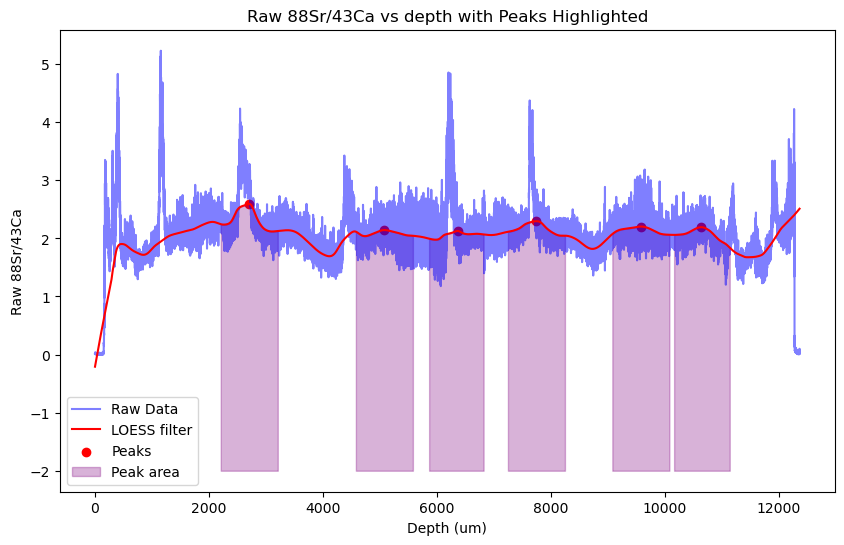

In [19]:
plt.figure(figsize = (10, 6))

plt.plot(ts2['depth'], ts2['proxy_filtered'], label = 'Raw Data', color = 'blue', alpha = 0.5) # Plot the Raw data
plt.plot(ts5['depth'], ts5['proxy_loess'], label = 'LOESS filter', color = 'red') # Plot the LOESS filter

# Plot the peaks
plt.scatter(pks2_depth, ts5['proxy_loess'].iloc[pks2_idx], color = 'red', label = 'Peaks')

# Shade the area under the LOESS filter curve for the full width of the peaks
for i in range(len(pks2_depth)):
    plt.fill_between(ts5['depth'], -2, ts5['proxy_loess'], where = (ts5['depth'] >= pks2_depth_left[i]) & (ts5['depth'] <= pks2_depth_right[i]), color = 'purple', alpha = 0.3, label = 'Peak area' if i == 0 else "")

plt.xlabel('Depth (um)')
plt.ylabel('Raw ' + proxy)
plt.title(f'Raw {proxy} vs depth with Peaks Highlighted')
plt.legend()
plt.show()

---
# ALGORITHM 3: D-square maxima followed by peak reduction

## Define D-Square algorithm

### Based on original code in Matlab by Frank Peeters, VU Amsterdam

In [20]:
def DSQUARE(Yin, WINDOW):
    """
    Yin           The data that is to be analysed
    WINDOW        Size of the window for which mean and variance will be
                  calculated before and after the point of interest
    """
    DSq = np.full_like(Yin, np.nan, dtype = np.float64) # Initialize the DSq array with NaN values
    for i in range(WINDOW, len(Yin) - WINDOW): # Loop through the data
        MUb = np.mean(Yin[i-WINDOW:i]) # MUb is average from window before point i
        VARb = np.var(Yin[i-WINDOW:i]) # VARb is variance from window before point i
        MUa = np.mean(Yin[i+1:i+1+WINDOW]) # MUa is average from window after point i
        VARa = np.var(Yin[i+1:i+1+WINDOW]) # VARa is variance from window after point i
        DSq[i] = (MUb - MUa)**2 / (VARb + VARa) # Calculate the D-Square value
    return DSq

## 9. Locate maxima in linearly spaces data using D-Square algorithm with a window of 200 and peak identification

In [21]:
# 5). LOCATE D-SQUARE MAXIMA
DSqa = DSQUARE(ts2_clean['proxy_filtered'], 200) # Calculate the D-Square values

# Use the find_peaks function to identify the peaks in the Gaussian filtered data
pks3a_idx, pksdict3a = find_peaks(DSqa, distance = 100, height = 0.4, width = [10, 1000])
pks3a_depth = ts2['depth'].iloc[pks3a_idx] # Get the depths of the peaks
pks3a_proxy = ts2_clean['proxy_filtered'].iloc[pks3a_idx] # Get the proxy values of the peaks
pks3a_depth_left = ts2['depth'].iloc[pksdict3a['left_ips']] # Get the left interpolated positions of the peaks
pks3a_depth_right = ts2['depth'].iloc[pksdict3a['right_ips']] # Get the right interpolated positions of the peaks

# Print details on the major peaks identified
print(f'{len(pks3a_depth)} peaks were identified in the data at these locations:')
for i in range(len(pks3a_depth)):
    print('Peak {}: Depth = {:.0f} - {:.0f} um with maximum at {:.0f} um, Proxy value = {:.2f} mmol/mol'.format(
        i + 1, pks3a_depth_left.iloc[i], pks3a_depth_right.iloc[i], pks3a_depth.iloc[i], pks3a_proxy.iloc[i]))

39 peaks were identified in the data at these locations:
Peak 1: Depth = 158 - 173 um with maximum at 165 um, Proxy value = 0.46 mmol/mol
Peak 2: Depth = 288 - 366 um with maximum at 347 um, Proxy value = 2.07 mmol/mol
Peak 3: Depth = 430 - 472 um with maximum at 450 um, Proxy value = 1.90 mmol/mol
Peak 4: Depth = 540 - 569 um with maximum at 558 um, Proxy value = 1.87 mmol/mol
Peak 5: Depth = 666 - 728 um with maximum at 697 um, Proxy value = 1.78 mmol/mol
Peak 6: Depth = 816 - 864 um with maximum at 842 um, Proxy value = 1.60 mmol/mol
Peak 7: Depth = 1002 - 1030 um with maximum at 1018 um, Proxy value = 1.74 mmol/mol
Peak 8: Depth = 1100 - 1134 um with maximum at 1123 um, Proxy value = 2.31 mmol/mol
Peak 9: Depth = 1208 - 1242 um with maximum at 1224 um, Proxy value = 2.28 mmol/mol
Peak 10: Depth = 2215 - 2264 um with maximum at 2234 um, Proxy value = 2.08 mmol/mol
Peak 11: Depth = 2501 - 2532 um with maximum at 2521 um, Proxy value = 2.56 mmol/mol
Peak 12: Depth = 2714 - 2750 um wit

## Plot locations of identified peaks on detrended and D-Square data

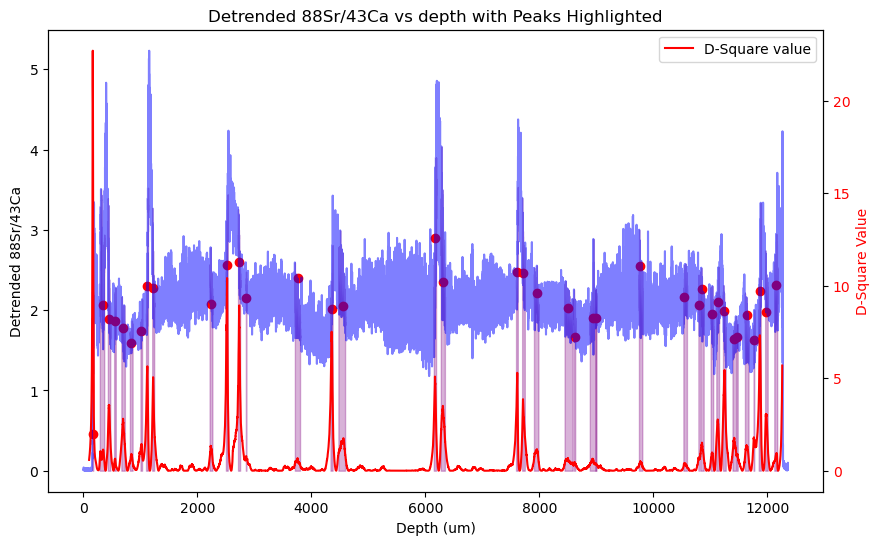

In [22]:
plt.figure(figsize = (10, 6))

plt.plot(ts3['depth'], ts2_clean['proxy_filtered'], label = 'Detrended Data', color = 'blue', alpha = 0.5)  # Plot the detrended data

# Shade the area under the Gaussian filter curve for the full width of the peaks
for i in range(len(pks3a_depth)):
    plt.fill_between(ts2['depth'], 0, ts2_clean['proxy_filtered'], where = (ts2['depth'] >= pks3a_depth_left.iloc[i]) & (ts2['depth'] <= pks3a_depth_right.iloc[i]), color = 'purple', alpha = 0.3, label = 'Peak area' if i == 0 else "")

# Plot the peaks
plt.scatter(pks3a_depth, pks3a_proxy, color = 'red', label = 'Peaks')

plt.xlabel('Depth (um)')
plt.ylabel('Detrended ' + proxy)

ax2 = plt.gca().twinx()  # Create a twin y-axis sharing the same x-axis
ax2.plot(ts2['depth'], DSqa, label = 'D-Square value', color = 'red')  # Plot the D-Square values
ax2.set_ylabel('D-Square Value', color = 'red')  # Set the label for the right y-axis
ax2.tick_params(axis = 'y', labelcolor = 'red')  # Set the tick parameters for the right y-axis

plt.title(f'Detrended {proxy} vs depth with Peaks Highlighted')
plt.legend()
plt.show()

## 10. Cluster to reduce the number of D-Square peaks

In [23]:
# CLUSTER REDUCTION D-SQUARE MAXIMA
clusterthreshold_microns = 300  # Cluster threshold in microns
clusterthreshold = clusterthreshold_microns / 0.5  # Convert the cluster threshold to number of data points

# Initialize variables
clusters = []  # List to store clusters
current_cluster = [pks3a_idx[0]]  # Start the first cluster with the first maximum

# Loop through the maxima
for i in range(1, len(pks3a_idx)):
    if pks3a_idx[i] - pks3a_idx[i - 1] < clusterthreshold:  # If the maxima are within the threshold
        current_cluster.append(pks3a_idx[i])  # Add the maximum to the current cluster
    else:
        clusters.append(current_cluster)  # Save the current cluster
        current_cluster = [pks3a_idx[i]]  # Start a new cluster

# Add the last cluster
if current_cluster:
    clusters.append(current_cluster)

# Reduce the clusters to their representative maxima and calculate statistics
# Initialize arrays to store the cluster statistics
pks3ac_idx = []
pks3ac_depth = []
pks3ac_proxy = []
pks3ac_depth_left = []
pks3ac_depth_right = []

# Process each cluster to extract statistics
for cluster in clusters:
    representative_idx = cluster[len(cluster) // 2]  # Middle point of the cluster
    depth_max = ts2['depth'].iloc[representative_idx]  # Depth of the maximum
    proxy_max = ts2['proxy_filtered'].iloc[representative_idx]  # Proxy value of the maximum
    left_boundary = ts2['depth'].iloc[min(cluster)]  # Left boundary of the cluster
    right_boundary = ts2['depth'].iloc[max(cluster)]  # Right boundary of the cluster

    # Append the results to the respective arrays
    pks3ac_idx.append(representative_idx)
    pks3ac_depth.append(depth_max)
    pks3ac_proxy.append(proxy_max)
    pks3ac_depth_left.append(left_boundary)
    pks3ac_depth_right.append(right_boundary)

# Convert lists to numpy arrays for consistency
pks3ac_idx = np.array(pks3ac_idx)
pks3ac_depth = np.array(pks3ac_depth)
pks3ac_proxy = np.array(pks3ac_proxy)
pks3ac_depth_left = np.array(pks3ac_depth_left)
pks3ac_depth_right = np.array(pks3ac_depth_right)

# Print details on the major peaks identified
print(f'{len(pks3ac_depth)} peaks were identified in the data at these locations:')
for i in range(len(pks3ac_depth)):
    print('Peak {}: Depth = {:.0f} - {:.0f} um with maximum at {:.0f} um, Proxy value = {:.2f} mmol/mol'.format(
        i + 1, pks3ac_depth_left[i], pks3ac_depth_right[i], pks3ac_depth[i], pks3ac_proxy[i]))


10 peaks were identified in the data at these locations:
Peak 1: Depth = 165 - 1224 um with maximum at 697 um, Proxy value = 1.78 mmol/mol
Peak 2: Depth = 2234 - 2856 um with maximum at 2734 um, Proxy value = 2.60 mmol/mol
Peak 3: Depth = 3758 - 3758 um with maximum at 3758 um, Proxy value = 2.40 mmol/mol
Peak 4: Depth = 4355 - 4562 um with maximum at 4562 um, Proxy value = 2.05 mmol/mol
Peak 5: Depth = 6168 - 6307 um with maximum at 6307 um, Proxy value = 2.36 mmol/mol
Peak 6: Depth = 7612 - 7956 um with maximum at 7712 um, Proxy value = 2.46 mmol/mol
Peak 7: Depth = 8496 - 8618 um with maximum at 8618 um, Proxy value = 1.67 mmol/mol
Peak 8: Depth = 8933 - 8986 um with maximum at 8986 um, Proxy value = 1.91 mmol/mol
Peak 9: Depth = 9769 - 9769 um with maximum at 9769 um, Proxy value = 2.55 mmol/mol
Peak 10: Depth = 10538 - 12160 um with maximum at 11419 um, Proxy value = 1.64 mmol/mol


## Plot locations of identified clustered peaks on detrended and D-Square data

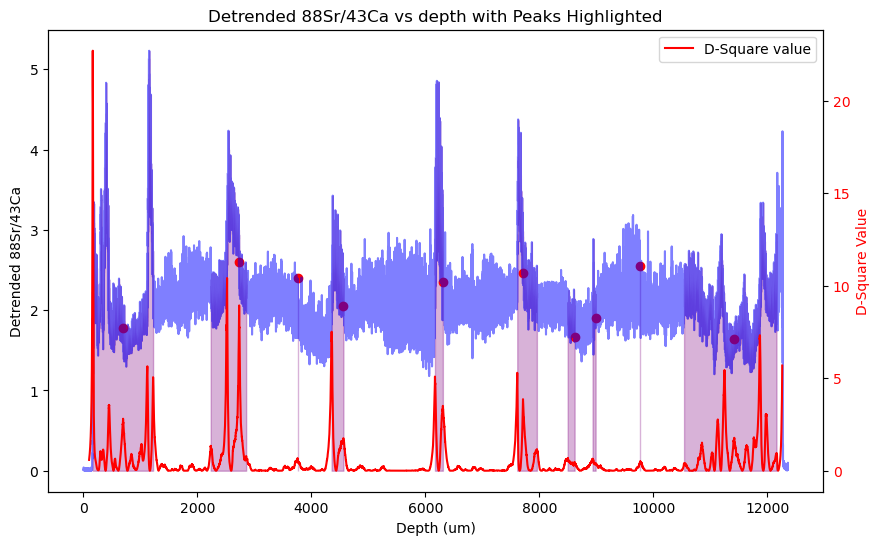

In [24]:
plt.figure(figsize = (10, 6))

plt.plot(ts3['depth'], ts2_clean['proxy_filtered'], label = 'Detrended Data', color = 'blue', alpha = 0.5)  # Plot the detrended data

# Shade the area under the Gaussian filter curve for the full width of the peaks
for i in range(len(pks3ac_depth)):
    plt.fill_between(ts2['depth'], 0, ts2_clean['proxy_filtered'], where = (ts2['depth'] >= pks3ac_depth_left[i]) & (ts2['depth'] <= pks3ac_depth_right[i]), color = 'purple', alpha = 0.3, label = 'Peak area' if i == 0 else "")

# Plot the peaks
plt.scatter(pks3ac_depth, pks3ac_proxy, color = 'red', label = 'Peaks')

plt.xlabel('Depth (um)')
plt.ylabel('Detrended ' + proxy)

ax2 = plt.gca().twinx()  # Create a twin y-axis sharing the same x-axis
ax2.plot(ts2['depth'], DSqa, label = 'D-Square value', color = 'red')  # Plot the D-Square values
ax2.set_ylabel('D-Square Value', color = 'red')  # Set the label for the right y-axis
ax2.tick_params(axis = 'y', labelcolor = 'red')  # Set the tick parameters for the right y-axis

plt.title(f'Detrended {proxy} vs depth with Peaks Highlighted')
plt.legend()
plt.show()

---
# 11. Combine the peak information from three methods

In [25]:
# Combine all the peak detection methods to arrive at one comprehensive estimate of the location of the peaks
# Combine the peak indices from all methods
all_peak_idx = np.concatenate((pks1_idx, pks2_idx, pks3ac_idx))  # Combine the peak indices from all methods and sort by index
all_peak_depth = np.concatenate((pks1_depth, pks2_depth, pks3ac_depth))  # Combine the peak depths from all methods and sort by index
all_peak_depth = all_peak_depth[np.argsort(all_peak_idx)]
all_peak_proxy = np.concatenate((pks1_proxy, pks2_proxy, pks3ac_proxy))  # Combine the peak proxies from all methods and sort by index
all_peak_proxy = all_peak_proxy[np.argsort(all_peak_idx)]
all_peak_depth_left = np.concatenate((pks1_depth_left, pks2_depth_left, pks3ac_depth_left))  # Combine the left interpolated positions of the peaks and sort by index
all_peak_depth_left = all_peak_depth_left[np.argsort(all_peak_idx)]
all_peak_depth_right = np.concatenate((pks1_depth_right, pks2_depth_right, pks3ac_depth_right))  # Combine the right interpolated positions of the peaks and sort by index
all_peak_depth_right = all_peak_depth_right[np.argsort(all_peak_idx)]
all_peak_method = np.concatenate(( # Combine the peak detection methods and sort by index
    np.full(len(pks1_idx), 'Gaussian filter', dtype = object),
    np.full(len(pks2_idx), 'LOESS filter', dtype = object),
    np.full(len(pks3ac_idx), 'D-Square', dtype = object)
))
all_peak_method = all_peak_method[np.argsort(all_peak_idx)]
all_peak_idx = np.sort(all_peak_idx)  # Sort the peak indices

# Create likelihood distributions for all peaks and include method information
likelihood_distributions = []
combined_std_dev = (all_peak_depth_right - all_peak_depth_left).mean() / 4  # Combined standard deviation for the likelihood distributions based on 1/4 of the mean range of the peaks (assuming +/- 2 SD covers the peak range)

for i in range(len(all_peak_depth)):
    peak_range = (ts2['depth'] >= all_peak_depth_left[i]) & (ts2['depth'] <= all_peak_depth_right[i])
    likelihood = np.zeros_like(ts2['depth'], dtype = float)
    likelihood[peak_range] = np.exp(-((ts2['depth'][peak_range] - all_peak_depth[i]) ** 2) / (2 * combined_std_dev ** 2))
    likelihood_distributions.append({
        'likelihood': likelihood,
        'method': all_peak_method[i]
    })

# Combine all likelihood distributions into a single array
combined_likelihood = np.sum([dist['likelihood'] for dist in likelihood_distributions], axis=0)

# Identify peaks in the combined likelihood distribution and label them
peak_indices, _ = find_peaks(combined_likelihood, height = 1)  # Find peaks with a value above 1
peak_numbers = range(1, len(peak_indices) + 1)  # Assign numbers to each peak

# Find depth, proxy value, left and right interpolated positions, and method for each peak
peak_depths = [None] * len(peak_indices)  # Create an empty list of length peak_indices
peak_proxies = [None] * len(peak_indices)  # Create an empty list of length peak_indices
peak_depth_lefts = [None] * len(peak_indices)  # Create an empty list of length peak_indices
peak_depth_rights = [None] * len(peak_indices)  # Create an empty list of length peak_indices
peak_methods = [None] * len(peak_indices)  # Create an empty list of length peak_indices

# Loop through the peak indices and extract the corresponding values from the original data
for i in range(len(peak_indices)):
    idx = peak_indices[i]  # Get the index of the peak in the combined likelihood distribution

    # Find the index of the closest value in all_peak_idx to the current idx
    peak_idx = np.argmin(np.abs(all_peak_idx - idx))
    peak_depths[i] = all_peak_depth[peak_idx] # Assign the depth of the peak
    peak_proxies[i] = all_peak_proxy[peak_idx] # Assign the proxy value of the peak
    peak_depth_lefts[i] = all_peak_depth_left[peak_idx] # Assign the left edge of the peak
    peak_depth_rights[i] = all_peak_depth_right[peak_idx] # Assign the right edge of the peak
    peak_methods[i] = all_peak_method[peak_idx] # Assign the method used to identify the peak


# Plot combined peak likelihood

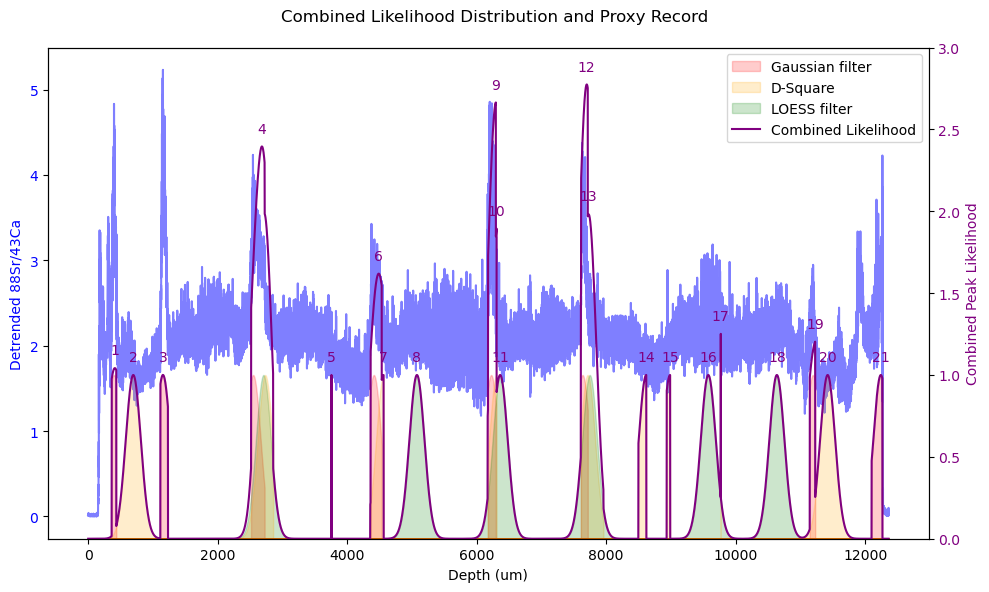

Plot saved to Cleanalyze_results/G767_sub_combined_likelihood_plot.png


In [26]:
# Plot the combined likelihood distribution on a separate y-axis
fig, ax1 = plt.subplots(figsize = (10, 6))

# Plot the proxy record on the primary y-axis
ax1.plot(ts2['depth'], ts2['proxy_filtered'], label = 'Proxy Record', color = 'blue', alpha = 0.5)
ax1.set_xlabel('Depth (um)')
ax1.set_ylabel('Detrended ' + proxy, color = 'blue')
ax1.tick_params(axis = 'y', labelcolor = 'blue')

# Create a secondary y-axis for the combined likelihood
ax2 = ax1.twinx()

# Plot individual likelihoods in the background with shaded colors
colors = {'Gaussian filter': 'red', 'LOESS filter': 'green', 'D-Square': 'orange'}
for dist in likelihood_distributions:
    ax2.fill_between(ts2['depth'], 0, dist['likelihood'], color = colors[dist['method']], alpha = 0.2, label = f"{dist['method']}")

# Plot the combined likelihood
ax2.plot(ts2['depth'], combined_likelihood, label = 'Combined Likelihood', color = 'purple')
ax2.set_ylabel('Combined Peak Likelihood', color = 'purple')
ax2.tick_params(axis = 'y', labelcolor = 'purple')
ax2.set_ylim(0, 3)  # Set the maximum value of the likelihood axis to 2

# Annotate the peaks with their numbers
for i, peak_idx in enumerate(peak_indices):
    ax2.annotate(f'{i + 1}', (ts2['depth'].iloc[peak_idx], combined_likelihood[peak_idx]),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='purple')

# Add a title and legends
fig.suptitle('Combined Likelihood Distribution and Proxy Record')
fig.tight_layout()

# Add a legend for the individual likelihoods
handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
ax2.legend(by_label.values(), by_label.keys(), loc = 'upper right')

plt.show()

# Save the plot in the Cleanalyze_results folder
output_folder = "Cleanalyze_results"
output_file = f"{output_folder}/{specimen}_combined_likelihood_plot.png"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Save the figure
fig.savefig(output_file, dpi=300)
print(f"Plot saved to {output_file}")

# 12. Peak selection and data processing

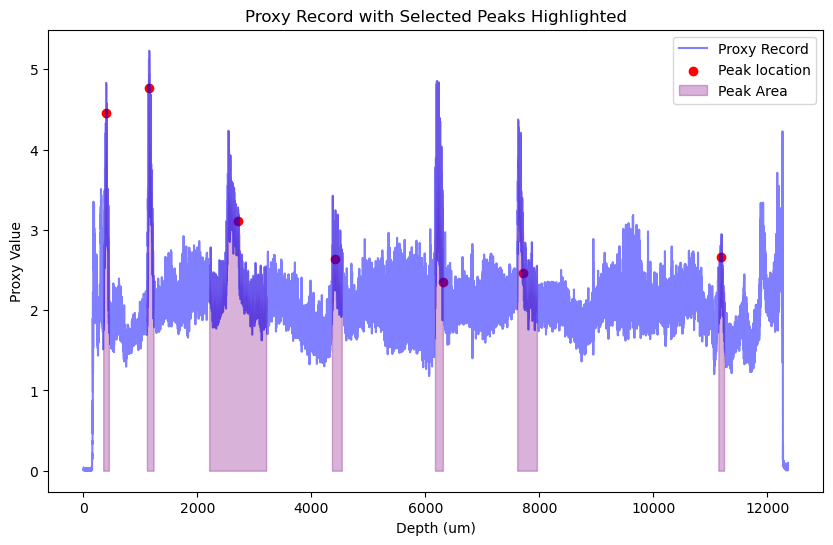

In [27]:
# Allow the user to select the peaks to keep
selected_peaks = [1, 3, 4, 6, 9, 12, 19]  # Replace with the indices of the peaks you want to keep (ideally 7 in total)

# Isolate the characteristics of the selected peaks
selected_indices = np.array([i - 1 for i in selected_peaks])
selected_peak_indices = peak_indices[selected_indices]
selected_peak_depths = np.array(peak_depths)[selected_indices]
selected_peak_proxy_values = np.array(peak_proxies)[selected_indices]
selected_peak_depth_lefts = np.array(peak_depth_lefts)[selected_indices]
selected_peak_depth_rights = np.array(peak_depth_rights)[selected_indices]

# Adjust the boundaries of selected peaks to ensure a minimum width of 100 micrometers
for i in range(len(selected_peak_depths)):
    peak_width = selected_peak_depth_rights[i] - selected_peak_depth_lefts[i]
    if peak_width < 100:
        half_width = 50  # Half of the desired minimum width
        center = selected_peak_depths[i]
        selected_peak_depth_lefts[i] = center - half_width
        selected_peak_depth_rights[i] = center + half_width

# Plot the record along with the selected peaks and shaded areas
plt.figure(figsize = (10, 6))

# Plot the proxy record
plt.plot(ts2['depth'], ts2['proxy_filtered'], label = 'Proxy Record', color = 'blue', alpha = 0.5)

# Highlight the selected peaks and shade the areas under the peaks
for i, peak_idx in enumerate(selected_peak_indices):
    plt.scatter(selected_peak_depths[i], selected_peak_proxy_values[i], color = 'red', label = f'Peak location' if i == 0 else "")
    plt.fill_between(ts2['depth'], 0, ts2['proxy_filtered'], where = (ts2['depth'] >= selected_peak_depth_lefts[i]) & (ts2['depth'] <= selected_peak_depth_rights[i]), color = 'purple', alpha = 0.3, label = 'Peak Area' if i == 0 else "")

# Add labels, title, and legend
plt.xlabel('Depth (um)')
plt.ylabel('Proxy Value')
plt.title('Proxy Record with Selected Peaks Highlighted')
plt.legend()
plt.show()

## Mark data intervals and export result for regressions

In [28]:
# Loop through selected peaks and mark each point in the filtered dataset based on whether it falls with a peak or between peaks

data_labeled = ts1.merge(data, on = 'depth', how = 'left') # Merge ts1 with original data based on the 'depth' column
data_labeled['peak'] = None # Initialize a new column to store peak information

for i, peak_idx in enumerate(selected_peak_indices):
    # Get the left and right bounds of the peak
    left_bound = selected_peak_depth_lefts[i]
    right_bound = selected_peak_depth_rights[i]

    # Mark points in data_labeled that fall within the peak bounds
    data_labeled.loc[(data_labeled['depth'] >= left_bound) & (data_labeled['depth'] <= right_bound), 'peak'] = f"peak {i + 1}"

# Label areas before the first peak
data_labeled.loc[data_labeled['depth'] < selected_peak_depth_lefts[0], 'peak'] = "interval 0"

# Label areas in between peaks
for j in range(len(selected_peak_depths) - 1):
    data_labeled.loc[
        (data_labeled['depth'] > selected_peak_depth_rights[j]) & 
        (data_labeled['depth'] < selected_peak_depth_lefts[j + 1]), 
        'peak'
    ] = f"interval {j + 1}"

# Label areas after the last peak
data_labeled.loc[data_labeled['depth'] > selected_peak_depth_rights[-1], 'peak'] = f"interval {len(selected_peak_depths)}"

# Save the updated data_labeled DataFrame with the peak information to a new CSV file
data_labeled.to_csv(f"Cleanalyze_results/{specimen}_peakid.csv", index = False)

## Plot data intervals and peak locations

C:\Users\nwi213\AppData\Local\Temp\ipykernel_6804\937924476.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  peak_cmap = get_cmap('Blues_r')  # Reverse the colormap for darker shades
C:\Users\nwi213\AppData\Local\Temp\ipykernel_6804\937924476.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  interval_cmap = get_cmap('Greens_r')  # Reverse the colormap for darker shades


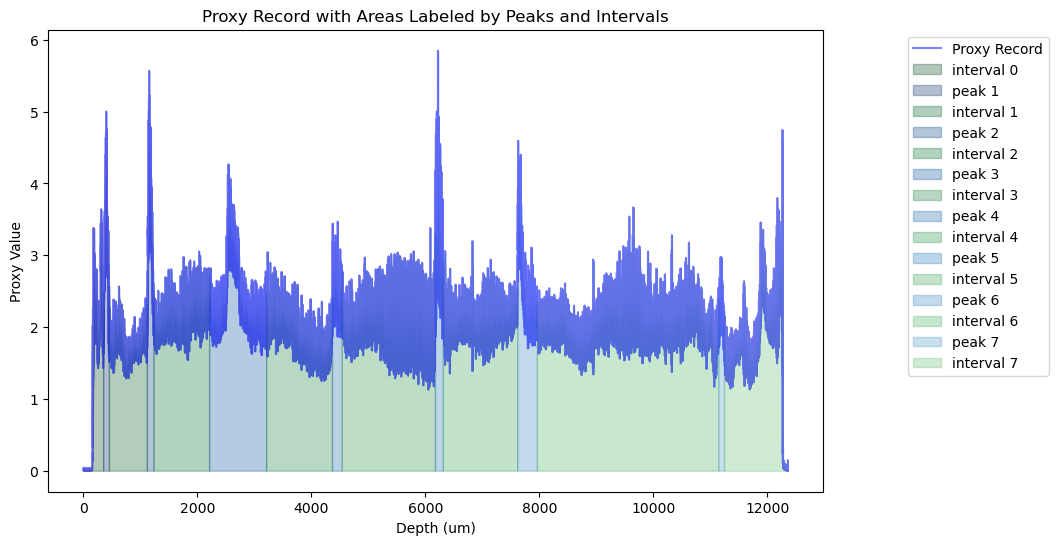

Plot saved to Cleanalyze_results/G767_sub_labeled_areas_plot.png


In [29]:
# Plot the proxy record with areas labeled based on the "peak" column
fig = plt.figure(figsize=(10, 6))

# Plot the proxy record
plt.plot(data_labeled['depth'], data_labeled['proxy_filtered'], label='Proxy Record', color='blue', alpha=0.5)

# Get unique labels in the "peak" column
unique_labels = data_labeled['peak'].unique()

# Create colormaps for peaks and intervals with darker shades
peak_cmap = get_cmap('Blues_r')  # Reverse the colormap for darker shades
interval_cmap = get_cmap('Greens_r')  # Reverse the colormap for darker shades

# Generate unique colors for peaks and intervals
peak_colors = {f"peak {i + 1}": peak_cmap(i / len(unique_labels)) for i in range(len(unique_labels)) if f"peak {i + 1}" in unique_labels}
interval_colors = {f"interval {i}": interval_cmap(i / len(unique_labels)) for i in range(len(unique_labels)) if f"interval {i}" in unique_labels}

# Plot shaded areas for peaks and intervals with unique colors
for label in unique_labels:
    label_indices = data_labeled[data_labeled['peak'] == label].index
    if 'peak' in label:
        plt.fill_between(
            data_labeled['depth'].iloc[label_indices],
            0,
            data_labeled['proxy_filtered'].iloc[label_indices],
            color=peak_colors[label],
            alpha=0.3,
            label=label if label not in plt.gca().get_legend_handles_labels()[1] else ""
        )
    elif 'interval' in label:
        plt.fill_between(
            data_labeled['depth'].iloc[label_indices],
            0,
            data_labeled['proxy_filtered'].iloc[label_indices],
            color=interval_colors[label],
            alpha=0.3,
            label=label if label not in plt.gca().get_legend_handles_labels()[1] else ""
        )

# Add labels, title, and legend
plt.xlabel('Depth (um)')
plt.ylabel('Proxy Value')
plt.title('Proxy Record with Areas Labeled by Peaks and Intervals')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

# Save the plot in the Cleanalyze_results folder
output_file = f"Cleanalyze_results/{specimen}_labeled_areas_plot.png"

# Save the figure
fig.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Plot saved to {output_file}")